In [114]:
import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import copy
import pandas as pd
from pathlib import Path
%matplotlib inline
import csv   

#### Script Description

This script takes in the MCeQ flux file and converts into a csv format
along with the bin edges.

In [115]:
# Load in the files
f=open("./MCEqFluxMeshes.pkl","rb")
EBins, cosas, bs, FluxMeshes= pickle.load(f)
f.close()

f=open("./LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()

LinInterps.keys()

dict_keys([100, 300, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000, 2000, 4000, 6000])

In [116]:
eps=0.01
survivalfractions=[]
correctedmeshes=[]

for ei in range(0,len(EBins)-2):
    
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    
    for ica in range(len(cosas)):
    
        for ib in range(len(bs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,bs[ib])
            survmesh[ica,ib]=surv
            mesh[ica,ib]=mesh[ica,ib]*surv
    
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)

In [117]:
intensity = []
azimuth      = []
zenith     = []


cosa_mesh, b_mesh=np.meshgrid(cosas, bs)
zenith_=np.arccos(cosas-4e-16) # 4e-16 factor introduced to remove erroneous cosas > 1

totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m


# Loop over the flux bins and get zenith and azimuth values to save to file
for y in range(0, len(totalflux)):
    for x in range(0, len(totalflux[y])):

        if (zenith_[y] != 0):
            intensity.append(totalflux[y][x])
            azimuth.append(bs[x]+np.pi)
            zenith.append(zenith_[y])

# Create a dictionary of the intensity, zenith and azimuth values to store
dict_ = {'Intensity':intensity, 'azimuth': azimuth, 'zenith': zenith}

# Dataframe from the dictionary
dataframe = pd.DataFrame(dict_)

# Write the data from hdf5 format to csv for reading into nexus
filepath = Path('SimulatedMuonsProposalMCEq.csv')  
dataframe.to_csv(filepath, index = False, header = False)  

# Save the bin edges to the file too

# Bin edges, shift to the left by the bin width/2 so bin center and edges are well defined
binEdges_azimuth = np.linspace(0-0.21666156/2.0, 2*np.pi-0.21666156/2.0,30)

binEdges_zenith = np.linspace(0.4-0.02/2.0, 1-0.02/2.0, 31)
binEdges_zenith = binEdges_zenith[::-1]
binEdges_zenith = np.arccos(binEdges_zenith)


# Add the edge bins
binEdges_azimuth_ = np.append(binEdges_azimuth,[2*np.pi])
binEdges_zenith_  = np.append([0], binEdges_zenith)

with open(r'SimulatedMuonsProposalMCEq.csv', 'a') as f:
    writer = csv.writer(f)
    
    # Write the zenith bin edges
    for i in range(len(binEdges_zenith_)):
        writer.writerow(['zenith', binEdges_zenith_[i]])

    # Write the zenith bin edges
    for i in range(len(binEdges_azimuth_)):
        writer.writerow(['azimuth',binEdges_azimuth_[i]])


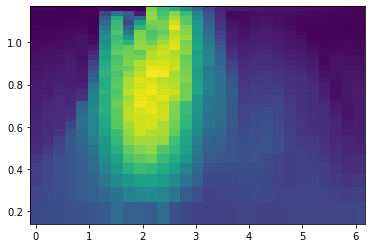

In [118]:
# Plot the histogram as a test
h, xedges, yedges, image = hist_data= plt.hist2d(dataframe["azimuth"], dataframe["zenith"], weights=dataframe["Intensity"], bins=[binEdges_azimuth, binEdges_zenith]) 
